In [170]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm_base, tqdm_notebook as tqdm

tqdm_base.pandas()

# installing geopandas on mac with conda is a pain, i recommend starting with a fresh conda env and...
# pip install geopandas numpy pandas shapely fiona six pyproj tables matplotlib tqdm

In [2]:
# because jan 18 is split across 2 gtfs feeds (https://transitfeeds.com/p/king-county-metro/)
# let's verify that route_id for D and E are consistent
# i downloaded/unzipped gtfs into ./data/source/gtfs_YYYYMMDD dirs
routes_1 = pd.read_csv('./data/source/gtfs_20171116/routes.txt')
routes_2 = pd.read_csv('./data/source/gtfs_20180118/routes.txt')

In [3]:
routes_1[(routes_1.route_short_name == 'D Line') | (routes_1.route_short_name == 'E Line')]

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
202,102581,KCM,D Line,NaN,Blue Ridge/Crown Hill - Ballard - Downtown Sea...,3,http://metro.kingcounty.gov/schedules/674/n0.html,NaN,NaN
205,102615,KCM,E Line,NaN,Aurora Village Transit Center - Downtown Seattle,3,http://metro.kingcounty.gov/schedules/675/n0.html,NaN,NaN


In [4]:
routes_2[(routes_2.route_short_name == 'D Line') | (routes_2.route_short_name == 'E Line')]

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
202,102581,KCM,D Line,NaN,Blue Ridge/Crown Hill - Ballard - Downtown Sea...,3,http://metro.kingcounty.gov/schedules/674/n0.html,NaN,NaN
205,102615,KCM,E Line,NaN,Aurora Village Transit Center - Downtown Seattle,3,http://metro.kingcounty.gov/schedules/675/n0.html,NaN,NaN


In [5]:
# route_id is unchanged
# D line = 102581
# E line = 102615

In [6]:
locations_df = pd.read_hdf('./data/intermed/positions_201801.h5', key='df')

In [7]:
locations_df[locations_df.route_id == 102581].shape

(167619, 8)

In [8]:
locations_df[locations_df.route_id == 102615].shape

(197432, 8)

In [9]:
# because E line has more locations and keith's suggested analysis highlights 2 segments, we'll look at E first:
# For the E, two segments to focus on:
# 1). Pine to Denny/Battery
# 2). Denny/Battery to Aurora/46th

In [10]:
e_df = locations_df[locations_df.route_id == 102615]

In [11]:
e_df.head()

,route_id,timestamp,trip_id,vehicle_id,vehicle_lat,vehicle_long,time_utc,time_pct
timestamp_tzone,,,,,,,,
2017-12-31 23:58:02,102615,1514764682,34922199,6081,47.774178,-122.342422,2017-12-31 23:58:02,2017-12-31 15:58:02-08:00
2017-12-31 23:58:28,102615,1514764708,34922112,6051,47.739391,-122.345238,2017-12-31 23:58:28,2017-12-31 15:58:28-08:00
2017-12-31 23:58:46,102615,1514764726,34922164,6211,47.694817,-122.344574,2017-12-31 23:58:46,2017-12-31 15:58:46-08:00
2017-12-31 23:59:03,102615,1514764743,34922084,6071,47.686714,-122.344505,2017-12-31 23:59:03,2017-12-31 15:59:03-08:00
2017-12-31 23:59:04,102615,1514764744,34922180,6088,47.618118,-122.343559,2017-12-31 23:59:04,2017-12-31 15:59:04-08:00


In [12]:
trips_df = pd.read_csv('./data/source/gtfs_20180118/trips.txt')
shapes_df = pd.read_csv('./data/source/gtfs_20180118/shapes.txt')

In [13]:
# it appears that direction_id = 0 for the E is northbound
trips_df[(trips_df.route_id == 102615) & (trips_df.direction_id == 0)].head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,peak_flag,fare_id
12478,102615,66726,34815718,Aurora Village Transit Center,LOCAL,0,4759418,11675003,1,112.0
12479,102615,66726,34815719,Aurora Village Transit Center,LOCAL,0,4759590,11675003,0,102.0
12481,102615,66726,34815721,Aurora Village Transit Center,LOCAL,0,4759415,11675003,1,112.0
12482,102615,66726,34815722,Aurora Village Transit Center,LOCAL,0,4759519,11675003,1,112.0
12483,102615,66726,34815723,Aurora Village Transit Center,LOCAL,0,4759412,11675003,0,102.0


In [14]:
e_shape = shapes_df[shapes_df.shape_id == 11675003]

In [15]:
e_shape.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
113213,11675003,47.601669,-122.330170,1,0.0
113214,11675003,47.601719,-122.330269,2,30.0
113215,11675003,47.601761,-122.330391,3,64.5
113216,11675003,47.601830,-122.330498,4,100.1
113217,11675003,47.601936,-122.330650,5,153.5


In [16]:
e_shape['coordinates'] = list(zip(e_shape.shape_pt_lon, e_shape.shape_pt_lat))
e_shape['coordinates'] = e_shape['coordinates'].apply(Point)

/Users/aps/miniconda3/envs/realtime_buses/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/aps/miniconda3/envs/realtime_buses/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
e_shape

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,coordinates
113213,11675003,47.601669,-122.330170,1,0.0,POINT (-122.33017 47.6016693)
113214,11675003,47.601719,-122.330269,2,30.0,POINT (-122.330269 47.6017189)
113215,11675003,47.601761,-122.330391,3,64.5,POINT (-122.330391 47.6017609)
113216,11675003,47.601830,-122.330498,4,100.1,POINT (-122.330498 47.6018295)
113217,11675003,47.601936,-122.330650,5,153.5,POINT (-122.33065 47.6019363)
113218,11675003,47.602058,-122.330757,6,205.6,POINT (-122.330757 47.6020584)
113219,11675003,47.602085,-122.330788,7,217.6,POINT (-122.330788 47.6020851)
113220,11675003,47.602764,-122.331413,8,511.7,POINT (-122.331413 47.6027641)
113221,11675003,47.603481,-122.332069,9,818.2,POINT (-122.332069 47.6034813)
113222,11675003,47.604153,-122.332672,10,1104.1,POINT (-122.332672 47.6041527)


In [18]:
gdf = geopandas.GeoDataFrame(e_shape, geometry='coordinates')

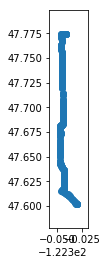

In [19]:
gdf.plot()
plt.show()

In [20]:
gdf.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,coordinates
113213,11675003,47.601669,-122.330170,1,0.0,POINT (-122.33017 47.6016693)
113214,11675003,47.601719,-122.330269,2,30.0,POINT (-122.330269 47.6017189)
113215,11675003,47.601761,-122.330391,3,64.5,POINT (-122.330391 47.6017609)
113216,11675003,47.601830,-122.330498,4,100.1,POINT (-122.330498 47.6018295)
113217,11675003,47.601936,-122.330650,5,153.5,POINT (-122.33065 47.6019363)


In [21]:
stops_df = pd.read_csv('./data/source/gtfs_20180118/stops.txt')

In [22]:
stops_df.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone
0,1000,NaN,Pine St & 9th Ave,NaN,47.613415,-122.332138,21,NaN,0,NaN,America/Los_Angeles
1,10000,NaN,NE 55th St & 43rd Ave NE,NaN,47.668575,-122.283653,1,NaN,0,NaN,America/Los_Angeles
2,10005,NaN,40th Ave NE & NE 51st St,NaN,47.665886,-122.284897,1,NaN,0,NaN,America/Los_Angeles
3,10010,NaN,NE 55th St & 39th Ave NE,NaN,47.668579,-122.285667,1,NaN,0,NaN,America/Los_Angeles
4,10020,NaN,NE 55th St & 37th Ave NE,NaN,47.668579,-122.288300,1,NaN,0,NaN,America/Los_Angeles


In [23]:
trips_df[trips_df.trip_id == 34815721]

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,peak_flag,fare_id
12481,102615,66726,34815721,Aurora Village Transit Center,LOCAL,0,4759415,11675003,1,112.0


In [25]:
# NEXT: to get stops for a route: route -> trips -> stop_times -> stops

In [30]:
e_trips = trips_df[trips_df.route_id == 102615]

In [37]:
e_trips[e_trips.direction_id == 0].head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,peak_flag,fare_id
12478,102615,66726,34815718,Aurora Village Transit Center,LOCAL,0,4759418,11675003,1,112.0
12479,102615,66726,34815719,Aurora Village Transit Center,LOCAL,0,4759590,11675003,0,102.0
12481,102615,66726,34815721,Aurora Village Transit Center,LOCAL,0,4759415,11675003,1,112.0
12482,102615,66726,34815722,Aurora Village Transit Center,LOCAL,0,4759519,11675003,1,112.0
12483,102615,66726,34815723,Aurora Village Transit Center,LOCAL,0,4759412,11675003,0,102.0


In [40]:
stop_times_df = pd.read_csv('./data/source/gtfs_20180118/stop_times.txt')

In [45]:
e_northbound_trip_ids = e_trips[e_trips.direction_id == 0]['trip_id']

In [52]:
e_northbound_stop_times = stop_times_df[stop_times_df['trip_id'].isin(e_northbound_trip_ids)]

In [59]:
e_north_stop_ids = e_northbound_stop_times['stop_id'].unique()
e_north_stop_ids

array([ 1610,   538,   558,   578,   600,   605,  6235,  6300,  6320,
       75409,  7630,  7670,  7690,  7710,  7730,  7750,  7770,  7790,
        7810,  7850,  7880,  7900,  7912, 75820, 75830, 75840, 75850,
       75860, 75870, 75881, 75890, 75901, 75910, 75932, 16103])

In [83]:
e_north_stops = stops_df[stops_df.stop_id.isin(e_north_stop_ids)]
e_north_stops = e_north_stops.loc[:, ['stop_id', 'stop_lat', 'stop_lon']]
e_north_stops.set_index('stop_id', inplace=True)
e_north_stops['coordinates'] = list(zip(e_north_stops.stop_lon, e_north_stops.stop_lat))
e_north_stops['coordinates'] = e_north_stops['coordinates'].apply(Point)
e_north_stops = e_north_stops.loc[:, ['coordinates']]

In [86]:
e_north_stops.head()

,coordinates
stop_id,
1610,POINT (-122.330101 47.60173029999999)
16103,POINT (-122.340881 47.77448270000001)
538,POINT (-122.332588 47.6041908)
558,POINT (-122.335213 47.6070518)
578,POINT (-122.338356 47.61048510000001)


In [87]:
e_northbound_trip_ids.head()

12478    34815718
12479    34815719
12481    34815721
12482    34815722
12483    34815723
Name: trip_id, dtype: int64

In [153]:
e_northbound_locations = locations_df[locations_df.trip_id.isin(e_northbound_trip_ids)]
e_northbound_locations = e_northbound_locations[['route_id', 'trip_id', 'vehicle_id', 'vehicle_lat', 'vehicle_long']]

In [154]:
e_northbound_locations.shape

(101360, 5)

In [95]:
e_df.shape

(197432, 8)

In [96]:
# that's good, our northbound e locations is approx 50% of previously calculated all e locations size

In [155]:
e_northbound_locations.head()

,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long
timestamp_tzone,,,,,
2017-12-31 23:58:46,102615,34922164,6211,47.694817,-122.344574
2017-12-31 23:59:04,102615,34922180,6088,47.618118,-122.343559
2017-12-31 23:59:05,102615,34922131,6054,47.774178,-122.342407
2017-12-31 23:59:22,102615,34922163,6062,47.755703,-122.345726
2018-01-01 00:00:08,102615,34922131,6054,47.774178,-122.342407


In [98]:
# now we need to find closest_stop_id from e_north_stops for all e_northbound_locations

In [105]:
e_north_stops.head()

,coordinates
stop_id,
1610,POINT (-122.330101 47.60173029999999)
16103,POINT (-122.340881 47.77448270000001)
538,POINT (-122.332588 47.6041908)
558,POINT (-122.335213 47.6070518)
578,POINT (-122.338356 47.61048510000001)


In [145]:
crs = {'init': 'epsg:4326'}
e_north_stops_gdf = gpd.GeoDataFrame(e_north_stops, crs=crs).set_geometry('coordinates')

def find_closest_stop_id(pnt):
    nearest = nearest_points(e_north_stops_gdf.geometry.unary_union, pnt)
    closest_coords = nearest[0]
    closest_stop = e_north_stops_gdf[e_north_stops_gdf['coordinates'] == closest_coords]
    return closest_stop.index[0]

In [146]:
pnt = Point(-122.344574, 47.694817)
find_closest_stop_id(pnt)

7750

In [165]:
e_northbound_locations['coordinates'] = e_northbound_locations.apply(lambda x: Point(x['vehicle_long'], x['vehicle_lat']), axis=1)

In [ ]:
# output cleared as tqdm generated 1000s of lines
e_northbound_locations['closest_stop_id'] = e_northbound_locations.progress_apply(lambda x: find_closest_stop_id(x['coordinates']), axis=1)

In [174]:
e_northbound_locations.head()

,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long,coordinates,closest_stop_id
timestamp_tzone,,,,,,,
2017-12-31 23:58:46,102615,34922164,6211,47.694817,-122.344574,POINT (-122.3445739746094 47.69481658935547),7750
2017-12-31 23:59:04,102615,34922180,6088,47.618118,-122.343559,POINT (-122.3435592651367 47.61811828613281),6235
2017-12-31 23:59:05,102615,34922131,6054,47.774178,-122.342407,POINT (-122.3424072265625 47.77417755126953),16103
2017-12-31 23:59:22,102615,34922163,6062,47.755703,-122.345726,POINT (-122.3457260131836 47.75570297241211),75881
2018-01-01 00:00:08,102615,34922131,6054,47.774178,-122.342407,POINT (-122.3424072265625 47.77417755126953),16103


In [181]:
e_northbound_locations = e_northbound_locations[['route_id', 'trip_id', 'vehicle_id','coordinates', 'closest_stop_id']]

In [184]:
e_northbound_locations.index.names = ['timestamp']
e_northbound_locations.head()

,route_id,trip_id,vehicle_id,coordinates,closest_stop_id
timestamp,,,,,
2017-12-31 23:58:46,102615,34922164,6211,POINT (-122.3445739746094 47.69481658935547),7750
2017-12-31 23:59:04,102615,34922180,6088,POINT (-122.3435592651367 47.61811828613281),6235
2017-12-31 23:59:05,102615,34922131,6054,POINT (-122.3424072265625 47.77417755126953),16103
2017-12-31 23:59:22,102615,34922163,6062,POINT (-122.3457260131836 47.75570297241211),75881
2018-01-01 00:00:08,102615,34922131,6054,POINT (-122.3424072265625 47.77417755126953),16103


In [187]:
e_northbound_locations.to_hdf('./data/intermed/e_northbound_locations_2018-01.h5', key='e_northbound_locations_gdf', mode='w')